<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/miRNA/blob/main/colab_ready_playground_with_preprocessed_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install torchmetrics

  Using cached torchmetrics-1.2.0-py3-none-any.whl (805 kB)
  Using cached lightning_utilities-0.9.0-py3-none-any.whl (23 kB)


In [1]:
# Modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/ML-Bioinfo-CEITEC/miRNA.git

Cloning into 'miRNA'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 132 (delta 53), reused 83 (delta 25), pack-reused 0
Receiving objects: 100% (132/132), 30.02 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [3]:
%cd miRNA

/content/miRNA


### Model training

In [16]:
DATASET_NAME = 'mirna_fcs'
MIRNA_NAMES = [
  'hsa-miR-106b-5p',
  'hsa-let-7c-5p',
  'hsa-miR-16-5p',
]
DATA_DIR = 'data'
RESULT_DIR = ''

RANDOM_STATE = 42
BATCH_SIZE = 32

In [25]:
import pandas as pd


input_dataset_file_path_train = 'data/{}.{}.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.zero_signal_to_negative.normalize.pkl'.format(
    DATASET_NAME,
    MIRNA_NAMES[0]
)
df_train = pd.read_pickle(input_dataset_file_path_train)

input_dataset_file_path_test = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.fill_empty_signal.pkl'.format(
    DATASET_NAME,
    MIRNA_NAMES[0]
)
df_test = pd.read_pickle(input_dataset_file_path_test)

for name in MIRNA_NAMES[1:]:
    input_dataset_file_path_train = 'data/{}.{}.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.zero_signal_to_negative.normalize.pkl'.format(
        DATASET_NAME,
        name
    )
    df_train = pd.concat(
        [df_train, pd.read_pickle(input_dataset_file_path_train)],
        axis='index',
        ignore_index=True,
    )

    input_dataset_file_path_test = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.fill_empty_signal.pkl'.format(
        DATASET_NAME,
        name
    )
    df_test = pd.concat(
        [df_test, pd.read_pickle(input_dataset_file_path_test)],
        axis='index',
        ignore_index=True,
    )

If you want to pad the signals to the length of the longest sequence

In [6]:
def pad_2d_array_to_longest_subarray_length(arr, pad_value=0):
    # Find the maximum length of sublists
    max_len = max(len(sublist) for sublist in arr)

    # Pad the sublists to max length
    padded_arr = [sublist + [pad_value] * (max_len - len(sublist)) for sublist in arr]

    return padded_arr

In [7]:
df_train['signal'] = pad_2d_array_to_longest_subarray_length(df_train['signal'])
df_test['signal'] = pad_2d_array_to_longest_subarray_length(df_test['signal'])

In [8]:
from sklearn.model_selection import train_test_split

#split validation set
df_train, df_val = train_test_split(
    df_train,
    test_size = 0.1,
    random_state = RANDOM_STATE,
    shuffle=True
)

In [ ]:
print(
    df_train['gene_symbol'].size,
    df_test['gene_symbol'].size,
    df_val['gene_symbol'].size,
)

10186 6101 1132


If you need pytorch dataloader

In [ ]:
from dataset import get_train_dataloader, get_val_dataloader, get_test_dataloader
import torch

train_loader = get_train_dataloader([torch.tensor(x) for x in df_train['signal']], df_train['fold_change'].values, BATCH_SIZE)
val_loader = get_val_dataloader([torch.tensor(x) for x in df_val['signal']], df_val['fold_change'].values, BATCH_SIZE)
test_loader = get_test_dataloader([torch.tensor(x) for x in df_test['signal']], df_test['fold_change'].values, BATCH_SIZE)

To plot precission-recall curve

In [24]:
# TODO merge your predictions to df_test
df_test['prediction']

1       0.0
4       0.0
5       0.0
7       0.0
8       0.0
       ... 
6091    0.0
6092    0.0
6093    0.0
6097    0.0
6098    0.0
Name: prediction, Length: 2282, dtype: float64

In [21]:
CLASS_THRESHOLD = -0.2
df_test['class'] = df_test['fold_change'] < CLASS_THRESHOLD

KeyError: ignored

KeyError: ignored

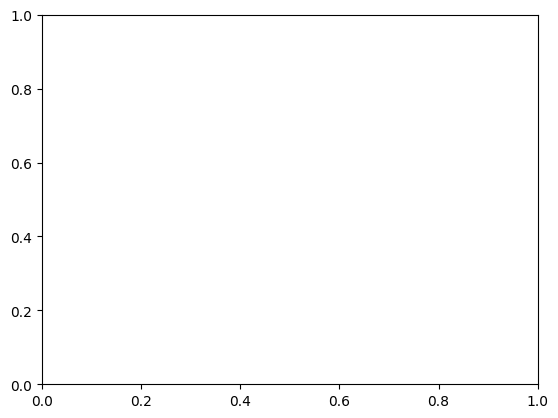

In [22]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
displ = PrecisionRecallDisplay.from_predictions(
    df_test['class'], -1 * df_test['prediction'],
    ax=ax,
    name='our prediction',
)
# PrecisionRecallDisplay.from_predictions(
#     df_test['class'], -1 * df_test['weighted context++ score'],
#     ax=ax,
#     name='weighted context++ score',
# )
ax.legend()
ax.set_title('PrecisionRecall.class_threshold: {}'.format(CLASS_THRESHOLD), loc='left', fontstyle='oblique', fontsize='medium')

output_path = "{}/PrecisionRecall.class_threshold_{}.jpg".format(
    RESULT_DIR,
    CLASS_THRESHOLD
)
fig.savefig(output_path)
plt.show()
